### Imports

In [1]:
import tensorflow as tf
tf.keras.backend.set_image_data_format("channels_last")

In [8]:
import os
import json
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn import metrics as sm
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, LSTM, Dropout, Embedding, Input
from tensorflow.keras.utils import pad_sequences
from tqdm import tqdm
import config as cfg
import itertools
import joblib
import glob

In [9]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                              cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    cm = np.round(cm, 3)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Define notebook parameters

In [12]:
## Get model saved (best) of the last timestamp file
list_of_files = glob.glob('model_store/*')
MODEL_PATH = max(list_of_files, key=os.path.getctime) + '/' + cfg.MODEL_FILE
MODEL_PATH

'model_store/1680599894.3332214/best_model.hdf5'

### Read train & validation

In [14]:
test_df = pd.read_csv(cfg.TEST_PATH)

### Preprocess data

In [15]:
test_df['content'] = test_df['content'].apply(str).apply(lambda x: x.lower())

test_df['content'] = test_df['content'].apply(lambda x: str(x).replace('\n', ' '))

test_df['content'] = test_df['content'].apply(lambda x: x.replace('\t', ' '))

test_df['content'] = test_df['content'].apply(lambda x: x.replace('  ', ' '))

test_df['content'] = test_df['content'].apply(lambda x: x.replace('"', ''))

test_df['content'] = test_df['content'].apply(lambda x: x.replace("'s", ""))

punctuation_signs = list("?:!.,;")

for punct_sign in punctuation_signs:   
    test_df['content'] = test_df['content'].str.replace(punct_sign, '')

test_df['is_sentitive'] = test_df['is_sentitive'].apply(lambda x: 1 if x=='true' else 0)

/home/ec2-user/.local/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  app.launch_new_instance()


### Prepare input model

In [16]:
with open(cfg.ENCODING_FILE, 'r') as fp:
    char_to_int = json.load(fp)

In [17]:
test_dataX = []
test_dataY = []

for i in tqdm(range(len(test_df))):
    test_seq = test_df['content'][i][:cfg.MAX_SEQUENCE_LENGTH]
    test_dataX.append([char_to_int[char] if char in char_to_int.keys() else len(char_to_int)+1 for char in test_seq])
    test_dataY.append(test_df['is_sentitive'][i])

100%|██████████| 6128787/6128787 [01:17<00:00, 79102.35it/s]


In [18]:
X_test = pad_sequences(test_dataX, maxlen=cfg.MAX_SEQUENCE_LENGTH, padding='post')

In [19]:
y_test = np.array(test_dataY).reshape(-1, 1)

### Load model

In [20]:
model = load_model(f'{MODEL_PATH}')

In [21]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 40)]              0         
                                                                 
 embeddings (Embedding)      (None, 40, 20)            99460     
                                                                 
 lstm_layer (LSTM)           (None, 50)                14200     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 30)                1530      
                                                                 
 dense_1 (Dense)             (None, 1)                 31        
                                                                 
Total params: 115,221
Trainable params: 115,221
Non-trainable

### Predict & see performance on test

In [22]:
test_predictions = model.predict(X_test)
test_df['predictions'] = test_predictions
print(f'AUC performance on all test is {roc_auc_score(y_test, test_predictions)}')

191525/191525 [==============================] - 830s 4ms/step
AUC performance on all test is 0.6452863804125359


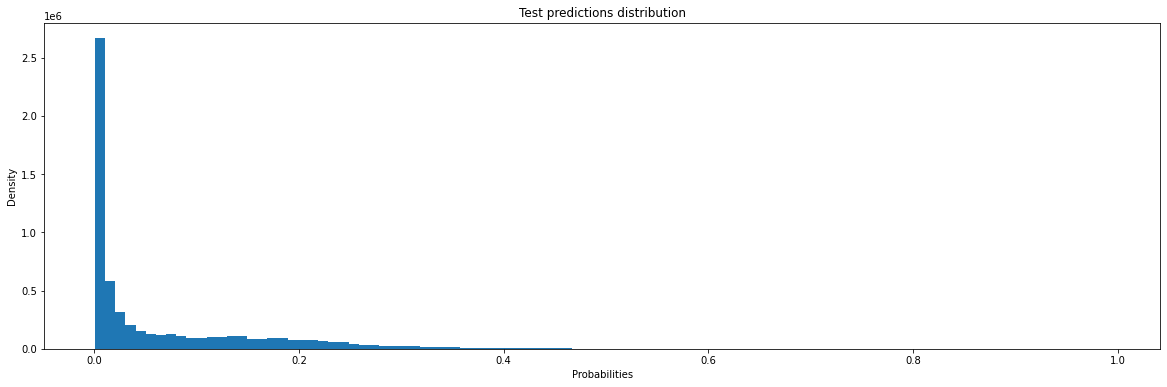

In [23]:
plt.figure(figsize=(20, 6))
plt.hist(test_predictions, bins=100)
plt.title('Test predictions distribution')
plt.xlabel('Probabilities')
plt.ylabel('Density')
plt.show()

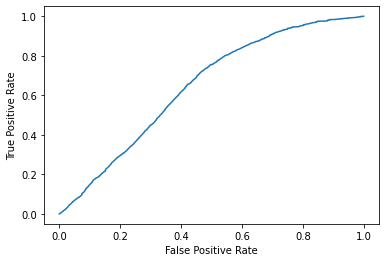

In [24]:
fpr, tpr, _ = sm.roc_curve(y_test, test_predictions)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Generate threshold table

In [25]:
tableau = pd.DataFrame()
for threshold in np.array(list(range(1, 20)))*0.05:
    threshold = np.round(threshold, 2)
    print(f'Threshold = {threshold}')
    test_predictions_labelled = (test_predictions >= threshold)
    ratio_1 = np.round(np.sum(test_predictions_labelled)/len(test_predictions), 4)
    CM = confusion_matrix(y_test, test_predictions_labelled)
    TN = CM[0][0]
    TP = CM[1][1]
    FP = CM[0][1]
    FN = CM[1][0]
    test_predictions_labelled_reversed = [not x for x in test_predictions_labelled]
    faux_negatifs = np.array([(y_test[i]*test_predictions_labelled_reversed[i])[0] for i in range(len(y_test))])
    sample_1_fn = test_df[faux_negatifs == 1].sample(1)
    sample_2_fn = test_df[faux_negatifs == 1].sample(1)
    sample_3_fn = test_df[faux_negatifs == 1].sample(1)
    msg_1_fn = sample_1_fn['content'].values[0]
    msg_2_fn = sample_2_fn['content'].values[0]
    msg_3_fn = sample_3_fn['content'].values[0]
    pred_1_fn = sample_1_fn['predictions'].values[0]
    pred_2_fn = sample_2_fn['predictions'].values[0]
    pred_3_fn = sample_3_fn['predictions'].values[0]
    y_test_reversed = [not x for x in y_test]
    faux_positifs = np.array([(y_test_reversed[i]*test_predictions_labelled[i])[0] for i in range(len(y_test))])
    sample_1_fp = test_df[faux_positifs == 1].sample(1)
    sample_2_fp = test_df[faux_positifs == 1].sample(1)
    sample_3_fp = test_df[faux_positifs == 1].sample(1)
    msg_1_fp = sample_1_fp['content'].values[0]
    msg_2_fp = sample_2_fp['content'].values[0]
    msg_3_fp = sample_3_fp['content'].values[0]
    pred_1_fp = sample_1_fp['predictions'].values[0]
    pred_2_fp = sample_2_fp['predictions'].values[0]
    pred_3_fp = sample_3_fp['predictions'].values[0]
    row = [threshold, ratio_1, TN, FN, TP, FP, msg_1_fn, pred_1_fn, msg_2_fn, pred_2_fn, msg_3_fn, pred_3_fn, msg_1_fp, pred_1_fp, msg_2_fp, pred_2_fp, msg_3_fp, pred_3_fp]
    temp = pd.DataFrame([row], columns=['seuil', 'taux de positifs', 'vrais negatifs', 'faux negatifs', 'vrais positifs', 'faux positifs', 'faux negatif exemple 1', 'prediction faux negatif exemple 1', 'faux negatif exemple 2', 'prediction faux negatif exemple 2', 'faux negatif exemple 3', 'prediction faux negatif exemple 3', 'faux positif exemple 1', 'prediction faux positif exemple 1', 'faux positif exemple 2', 'prediction faux positif exemple 2', 'faux positif exemple 3', 'prediction faux positif exemple 3'])
    tableau = pd.concat([tableau, temp])

Threshold = 0.05
Threshold = 0.1
Threshold = 0.15
Threshold = 0.2
Threshold = 0.25
Threshold = 0.3
Threshold = 0.35
Threshold = 0.4
Threshold = 0.45
Threshold = 0.5
Threshold = 0.55
Threshold = 0.6
Threshold = 0.65
Threshold = 0.7
Threshold = 0.75
Threshold = 0.8
Threshold = 0.85
Threshold = 0.9
Threshold = 0.95


In [26]:
tableau

,seuil,taux de positifs,vrais negatifs,faux negatifs,vrais positifs,faux positifs,faux negatif exemple 1,prediction faux negatif exemple 1,faux negatif exemple 2,prediction faux negatif exemple 2,faux negatif exemple 3,prediction faux negatif exemple 3,faux positif exemple 1,prediction faux positif exemple 1,faux positif exemple 2,prediction faux positif exemple 2,faux positif exemple 3,prediction faux positif exemple 3
0,0.05,0.3603,3866752,54080,64911,2143044,fuck him let me get you right gng,0.003503,proceeds to give me his number,0.004902,no shaking the bed either xxx,0.010957,ima lazy bum😔🧟,0.192545,also mb i barely go on hefe,0.325451,wazzam,0.421764
0,0.10,0.2630,4443264,73417,45574,1566532,u got snap,0.021089,when should i come pick you up,0.007668,ty yh sure,0.002818,and what’s your ethnicity,0.265333,and my legs wide open fr,0.162110,wbu do have any u wanna get,0.119187
0,0.15,0.1789,4945125,87447,31544,1064671,u send,0.000725,is that snap or insta,0.088166,suck ur dads balls,0.036213,machine gun kelly,0.327887,unfortunate,0.287688,want u,0.167880
0,0.20,0.1095,5357929,99828,19163,651867,u send,0.000800,its acc one of my favs,0.024765,cool tik tok i guess,0.002457,that’s not rude😭,0.230047,oliviagoderree,0.439350,what’s that supposed to mean,0.230222
0,0.25,0.0561,5674706,110025,8966,335090,wanker,0.169259,calling me clapped when u just called me leng ...,0.025984,whats ur instaaa,0.116021,mines close😪,0.429837,maneater vibes,0.377612,aight then,0.368733
0,0.30,0.0306,5827199,114197,4794,182597,playboykeeley,0.006846,ft gc,0.008162,boy what,0.101715,start with the knees so you can't get away,0.319423,noodles are almost done,0.416378,black owned,0.505226
0,0.35,0.0165,5910807,116719,2272,98989,your gonna suck my dick x,0.012280,fuck valentines day,0.027154,cock,0.000582,batman and superman are lengggg,0.406943,man gtfooo😒😒😒,0.472257,but you'd be cuter if i could call u mines 😉💕,0.434956
0,0.40,0.0089,5956194,117854,1137,53602,what’s ur insta,0.159761,l roaming lte * < 4mb3r111 0 posts 226 follow...,0.078804,masturbatingggg,0.259052,still waitin for my daily “ily black man”😪,0.654407,wasn’t a joke,0.489537,a bollywood movie,0.479965
0,0.45,0.0050,5979995,118407,584,29801,u send,0.000725,shii ima black woman enthusiast so wsp,0.108536,can i get yo snap,0.078853,you're handsome love,0.604679,i'm good,0.477255,i love tomatoes,0.580071
0,0.50,0.0028,5992764,118659,332,17032,get the fooking slags in,0.144863,you look you sell soul,0.002714,f4f on insta,0.075333,whats ur fav pokemon,0.519838,baseball football swimmjng,0.501657,what u look like,0.603844
